<a href="https://colab.research.google.com/github/kushal8112/FOCAL_nlp/blob/main/BERT_based_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FOCAL (Function of Citation in Astrophysics Literature)

In [ ]:
!pip install transformers # importing the transformers

In [ ]:
import pandas as pd
import numpy as np
import re
import copy
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
import matplotlib.pyplot as plt

In [ ]:
# import pandas as pd
# import json

# data1 = []
# with open('FOCAL-VALIDATION-NO-LABELS.jsonl', 'r') as file:
#     for line in file:
#         data1.append(json.loads(line))

# df1 = pd.DataFrame(data1)
# df1.head()

### Preprocessing the dataset to a suitable form for training

In [ ]:
df = pd.read_parquet("FOCAL_data.parquet")
dat = df['Functions Label']
data = df.copy()

def labels(dat):
    x=0
    a = []
    for i in range(len(dat)):
       for j in range(len(dat[i])):
           x=x+1
           if dat[i][j] not in a:
               a.append(dat[i][j])
    return(a,x)

labels,x = labels(dat)
#labels = ['Background', 'Compare/Contrast', 'Uses', 'Motivation', 'Extends', 'Similarities', 'Differences', 'Future Work']
labe = [0,1,2,3,4,5,6,7]

du = np.ones((x,1))
functxt = pd.DataFrame(du,columns=["Functions Text"])
funclab = pd.DataFrame(du,columns=["Functions Label"])
ft = data["Functions Text"].copy()
fl = data["Functions Label"].copy()
f=0
l=10
for i in range(0,len(fl)):
  for j in range(0,len(fl[i])):
    functxt.iloc[f] = ft[i][j]
    t = labels.index(fl[i][j])
    funclab.iloc[f] = labe[t]
    f=f+1
    if(len(ft[i][j])>=l):
      l = len(ft[i][j])
l = 512
Functions = functxt.join(funclab)
Functions["Functions Label"] = Functions["Functions Label"].astype('int')
Functions

,Functions Text,Functions Label
0,Several modelling works on this comet have sho...,0
1,as well as strong AGN/QSO and Supernova feedba...,0
2,"Indeed, large atomic gas reservoirs, together ...",1
3,and stellar masses,1
4,indicate that GRB hosts are preferentially gal...,1
...,...,...
3780,Through the work of Švestka & Fritzová-Švestko...,0
3781,(1982,0
3782,"1983b), Cane & Stone (1984), Klecker et al. (1...",0
3783,At the supranuclear densities of the outer cor...,2


### Tokenizing

In [ ]:
X_input_ids = np.zeros((x , l))
X_attn_masks = np.zeros((x , l))


tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
def generate_training_data(d, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(d["Functions Text"])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=l,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks


X_input_ids, X_attn_masks = generate_training_data(Functions, X_input_ids, X_attn_masks, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

0it [00:00, ?it/s]

### Categorical Encoding

In [ ]:
labels = np.zeros((x, 8))
labels[np.arange(x), Functions["Functions Label"].values] = 1

### Creating the dataset for training the model

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
def LabelDatasetMapFunction(input_ids, attn_masks, labels):
    return {'input_ids': input_ids,'attention_mask': attn_masks}, labels
dataset = dataset.map(LabelDatasetMapFunction)
dataset = dataset.shuffle(10000).batch(2, drop_remainder=True)
p = 0.8
train_size = int((x/2)*p)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)
train_dataset

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(2, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(2, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(2, 8), dtype=tf.float64, name=None))>

### Training the model

In [ ]:
from transformers import TFAutoModel

In [ ]:
model = TFAutoModel.from_pretrained('bert-base-cased')

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
input_ids = tf.keras.layers.Input(shape=(l,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(l,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(1024, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(8, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

label_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
label_model.summary()

optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

label_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [ ]:
hist = label_model.fit(train_dataset, validation_data=val_dataset, epochs = 5)

Epoch 1/5
1514/1514 [==============================] - 423s 270ms/step - loss: 1.3372 - accuracy: 0.5307 - val_loss: 1.0470 - val_accuracy: 0.6415
Epoch 2/5
1514/1514 [==============================] - 414s 273ms/step - loss: 1.0304 - accuracy: 0.6605 - val_loss: 0.6928 - val_accuracy: 0.7738
Epoch 3/5
1514/1514 [==============================] - 427s 282ms/step - loss: 0.7515 - accuracy: 0.7510 - val_loss: 0.4682 - val_accuracy: 0.8545
Epoch 4/5
1514/1514 [==============================] - 416s 275ms/step - loss: 0.5173 - accuracy: 0.8293 - val_loss: 0.3255 - val_accuracy: 0.8942
Epoch 5/5
1514/1514 [==============================] - 417s 275ms/step - loss: 0.3719 - accuracy: 0.8841 - val_loss: 0.1944 - val_accuracy: 0.9471


In [ ]:
label_model.save('label_model')

In [ ]:
label_model = tf.keras.models.load_model('label_model')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=512,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['Background', 'Compare/Contrast', 'Uses', 'Motivation', 'Extends', 'Similarities', 'Differences', 'Future Work']):
  finall=[]
  for i in processed_data:
    probs = model.predict(i)[0]
    finall.append(classes[np.argmax(probs)])
  return finall

# processed_data = prepare_data(input_text, tokenizer)
# result = make_prediction(label_model, processed_data=processed_data)
# print(f"Predicted Sentiment: {result}")

### Extracting the Function text

In [ ]:
data = pd.read_parquet("Validation_606.parquet")
input_data = data.loc[:,["Identifier","Paragraph","Citation Start End","Citation Text"]]
output_data = data.loc[:,["Functions Text","Functions Start End","Functions Label"]]

a = np.array([],dtype='int')
b = np.array([],dtype='int')
c = data["Paragraph"].copy()
citxt = data["Paragraph"].copy()
para = data["Paragraph"].copy()
s=np.ones((len(data.iloc[:,0]),1),dtype='int')
start_index = np.ones((len(data.iloc[:,0]),1),dtype='int')
total = len(c)

def immediate_character(cz,vf):
    for j in range(vf,len(cz)):
        if cz[j] == '.':
            return int(j+1)
            break

for i in range(0,total):
    a = np.append(a,int(input_data.loc[:,"Citation Start End"][i][0][0]))
    b = np.append(b,int(input_data.loc[:,"Citation Start End"][i][0][1]))
    c[i] = c[i].replace("al. ","al# ")
    c[i] = c[i].replace("e.g.","e g ")
    c[i] = c[i].replace("Fig.","Fig}")
    c[i] = c[i].replace("{.","{]")
    citxt.iloc[i] = c[i][a[i]:b[i]]
data.head()

,Identifier,Paragraph,Citation Text,Functions Text,Functions Label,Citation Start End,Functions Start End
0,2021ApJ...914..136C__Choe_et_al._2017_Instance_1,"PYU+ formed from HC3N and H2NCO+, having at le...",[Choe et al. 2017],[The method has been described elsewhere],[Background],"[[530, 546]]","[[454, 493]]"
1,2022AandA...657A..96A__Küpper_et_al._2002_Inst...,The availability of two rotational transitions...,[Küpper et al. 2002],[This fact is expected based on the low dipole...,"[Similarities, Uses]","[[585, 603]]","[[512, 583], [606, 719]]"
2,2016AandA...592A..19C__Johansson_et_al._2012a_...,Figure 24 shows that the median Re increases f...,[Johansson et al. 2012a],"[On the other hand, we cannot exclude the poss...",[Compare/Contrast],"[[902, 924]]","[[671, 882]]"
3,2016MNRAS.462.1415C__Gonzalez-Perez_et_al._201...,"Over the last 15 yr, our understanding of how ...",[Gonzalez-Perez et al. 2014],[This progress has led to a general consensus ...,"[Background, Background]","[[762, 788]]","[[615, 761], [874, 1205]]"
4,2018ApJ...854...26L___2015a_Instance_2,The hot emission line of Fe xxi 1354.09 Å and ...,[Li et al. 2015a],[In order to extract the hot line of Fe xxi 13...,"[Uses, Uses, Uses]","[[1373, 1388]]","[[1128, 1215], [1248, 1372], [1396, 1566]]"


### Extracting the function line

In [ ]:
y=np.ones((len(data.iloc[:,0]),1),dtype='int')
endy=np.ones((len(data.iloc[:,0]),1),dtype='int')
e = data["Paragraph"].copy()
funcind = data["Paragraph"].copy()
function_index = []
for i in range(0,total):
    x = 0
    d = re.split(r'\.',c[i])
    for lines in d:
        lines = lines + "."
        if (len(lines)+x)>=a[i]:
            e.iloc[i] = lines
            s[i] = immediate_character(c[i],x)
            y[i] = a[i] - s[i]
            endy[i] = y[i] + (b[i]-a[i])
            e[i] = e[i].replace("e g ","e.g.")
            e[i] = e[i].replace("Fig}","Fig.")
            e[i] = e[i].replace("{]","{.")
            e[i] = e[i].replace("al# ","al. ")
            funcind[i] = e[i]
            e[i] = [e[i][:int(y[i])-1],e[i][int(endy[i])+1:]]
            function_index.append(e[i])
            #print(e[i])
            start_index[i] = int(x)
            break
        x+=len(lines)

### Regular Expressions

In [ ]:
regex1 = re.compile(r"\(?(\w+)\-?\s*?(\w*)? et al. \(?(\d+)?[a-zA-z]?\)?\,?\)?\;?")
#designed to match variations of the "et al." abbreviation in academic citations.
regex2 = re.compile(r"\(?(\w+)\-?\s*?(\w*)? & (\w+)\-?\s*?(\w*)?\s*?\(?(\d+)[a-zA-z]?\)?\,?\)?\;?")
#designed for cases where multiple authors are separated by an ampersand (&).
regex3 = re.compile(r"\(?([A-Z]\w+)\-?\s*(\w*)?, (\w+)\-?\s*?(\w*)? & (\w+)\-?\s*?(\w*)?\s*?\(?(\d+)[a-zA-z]?\)?\,?\)?\;?")
# handles cases where there are three authors, with the first author's last name followed by a comma.
regex4 = re.compile(r"\(?([A-Z]\w+)\-?\s*?(\w*)? \((\d+)[a-zA-Z]?\)\,?\)?\;?")
#Targets cases where there is only one author and a publication year enclosed in parentheses.
regex10 = re.compile(r"\(?([A-Z]\w+)\-?\s*?(\w*)? (\d+)[a-zA-Z]?\,?\)?\;?")
#Similar to regex4 but without the parentheses around the publication year.
regex11 = re.compile(r"\((\d+)[a-zA-z]?  ")
#Captures a publication year within parentheses at the beginning of a sequence.
regex12 = re.compile(r"  (\d+)[a-zA-z]?\)")
#Captures a standalone publication year followed by a semicolon.
regex5 = re.compile(r"(\d+)\;")
#This regex is designed to match one or more whitespace characters.
finalreg = re.compile(r" \s+")

In [ ]:
for i in range(0,total):
    for j in range(0,len(e[i])):
      e[i][j] = regex10.sub("",regex4.sub("",regex2.sub("",regex3.sub("",regex1.sub("",e[i][j])))))
      e[i][j] = regex5.sub("",regex11.sub("",regex12.sub("",e[i][j])))
      e[i][j] = e[i][j].replace("M20","")
      e[i][j] = e[i][j].replace("PaperII","")
      e[i][j] = finalreg.sub(" ",e[i][j])
      if e[i][j] == " ." or e[i][j] == ". " or e[i][j] == " . " or e[i][j] == ".":
          del e[i][j]

In [ ]:
def remove_empty_elements(e):
    for i in range(total):
        try:
            for j in range(len(e[i])):
                if e[i][j] == '':
                    del e[i][j]
        except IndexError:
            pass

remove_empty_elements(e)
function_index = [copy.deepcopy(item) for item in e]

### Extracting Function indexes

In [ ]:
for i in range(0,total):
  l=0
  for j in range(0,len(e[i])):
    if l==0:
      start,end=0,0
      r = (re.split(r' ',e[i][j]))
      if r[0] != ' ' and r[0] != '':
          start = start_index[i]+funcind[i].find(r[0])+1
          #print(i,j)
      else:
          start = start_index[i]+funcind[i].find(r[1])+1
          #print(i,j)

      if r[-1] != '.' and r[-1] != ' ' and r[-1] != '':
          end = start_index[i]+funcind[i].rfind(r[-1])+len(r[-1])
          #print(i,j)
      elif r[-2] != ' ':
          end = start_index[i]+funcind[i].rfind(r[-2])+len(r[-2])
          #print(i,j)
      else:
          end = start_index[i]+funcind[i].rfind(r[-3])+len(r[-3])
          #print(i,j)
      function_index[i][j] = (int(start),int(end))
      l=l+1

    else:
      r = (re.split(r' ',e[i][j]))
      if r[0] != ' ' and r[0] != '':
          start = len(funcind[i][:int(endy[i])]) + start_index[i]+funcind[i][int(endy[i]):].find(r[0])+1
          #print(funcind[i][int(endy[i]):])
      else:
          start = len(funcind[i][:int(endy[i])]) + start_index[i]+funcind[i][int(endy[i]):].find(r[1])+1
          #print(funcind[i][int(endy[i]):])

      if r[-1] != '.' and r[-1] != ' ' and r[-1] != '':
          end = start_index[i]+funcind[i].rfind(r[-1])+len(r[-1])
          #print(i,j)
      elif r[-2] != ' ':
          end = start_index[i]+funcind[i].rfind(r[-2])+len(r[-2])
          #print(i,j)
      else:
          end = start_index[i]+funcind[i].rfind(r[-3])+len(r[-3])
          #print(i,j)
      function_index[i][j] = (int(start)-1,int(end))
    function_index[i]=list(function_index[i])

function_text = e.copy()


### Preprocessing the dataset

In [ ]:
def number_of_elements(dat):
  x=0
  for i in range(len(dat)):
      for j in range(len(dat[i])):
          x=x+1
  return x

xx = number_of_elements(function_text)

def preprocess_data(fun):
  du = np.ones((xx,1))
  funtxt = []
  f=0
  l=10
  for i in range(0,len(fun)):
    for j in range(0,len(fun[i])):
      funtxt.append(fun[i][j])
      f=f+1
  return(funtxt)
fnc = preprocess_data(function_text)

### Tokenizing

In [ ]:
dup = np.ones((xx,1))
fnclab = pd.DataFrame(dup,columns=["Functions Label"])
g=[]
for i in range(0,len(fnc)):
  input_text = fnc[i]
  processed_data = prepare_data(input_text, tokenizer)
  g.append(processed_data)
  #result = make_prediction(label_model, processed_data=processed_data)
  #fnclab.iloc[i] = result

In [ ]:
predicted_outcome = make_prediction(label_model,processed_data = g)

1/1 [==============================] - 0s 124ms/step


In [ ]:
print(xx)
len(predicted_outcome)

936


936

In [ ]:
a = len(function_text)

def Final_Output(predicted_data):
  lo = 0
  output_data = [copy.deepcopy(item) for item in function_text]
  for i in range(0,a):
    for j in range(0,len(output_data[i])):
      output_data[i][j] = predicted_data[lo]
      lo+=1
  return output_data
functionss_label = Final_Output(predicted_outcome)
len(functionss_label)

606

In [ ]:
#print(list(function_text))
f = np.ones((len(function_index),7),dtype='object')
for i in range(0,len(function_index)):
  f[i,0] = data["Identifier"][i]
  f[i,1] = data["Paragraph"][i]
  f[i,2] = data["Citation Start End"][i]
  f[i,3] = citxt[i]
  f[i,4] = function_text[i]
  f[i,5] = functionss_label[i]
  f[i,6] = function_index[i]
Final_Dataframe = pd.DataFrame(f)
Final_Dataframe.columns = ['Identifier', 'Paragraph', 'Citation Start End', 'Citation Text','Functions Text','Functions Label', 'Functions Start End']
Final_Dataframe.head()

,Identifier,Paragraph,Citation Start End,Citation Text,Functions Text,Functions Label,Functions Start End
0,2021ApJ...914..136C__Choe_et_al._2017_Instance_1,"PYU+ formed from HC3N and H2NCO+, having at le...","[[530, 546]]",Choe et al# 2017,[ The method has been described elsewhere ],[Background],"[(455, 493)]"
1,2022AandA...657A..96A__Küpper_et_al._2002_Inst...,The availability of two rotational transitions...,"[[585, 603]]",Küpper et al# 2002,"[150 D;, , which implies low critical densitie...","[Background, Compare/Contrast]","[(579, 584), (604, 671)]"
2,2016AandA...592A..19C__Johansson_et_al._2012a_...,Figure 24 shows that the median Re increases f...,"[[902, 924]]",Johansson et al# 2012a,"[ On the other hand, we cannot exclude the pos...",[Compare/Contrast],"[(672, 882)]"
3,2016MNRAS.462.1415C__Gonzalez-Perez_et_al._201...,"Over the last 15 yr, our understanding of how ...","[[762, 788]]",Gonzalez-Perez et al# 2014,[ This progress has led to a general consensus...,"[Background, Background]","[(616, 761), (874, 1205)]"
4,2018ApJ...854...26L___2015a_Instance_2,The hot emission line of Fe xxi 1354.09 Å and ...,"[[1373, 1388]]",Li et al# 2015a,[ we apply a multi-Gaussian function superimpo...,"[Uses, Uses]","[(1251, 1372), (1390, 1430)]"


In [ ]:
an = " ".join(function_text[5])
dd = " ".join(list(data["Functions Text"][5])) # changing data to  Final_Dataframe
ftn = re.split(r" ",dd)
c=0
for i in range(len(ftn)):
  if(ftn[i] in an):
    d = an.find(ftn[i])
    an = an[:d] + an[d+len(ftn[i]):]
    c=c+1

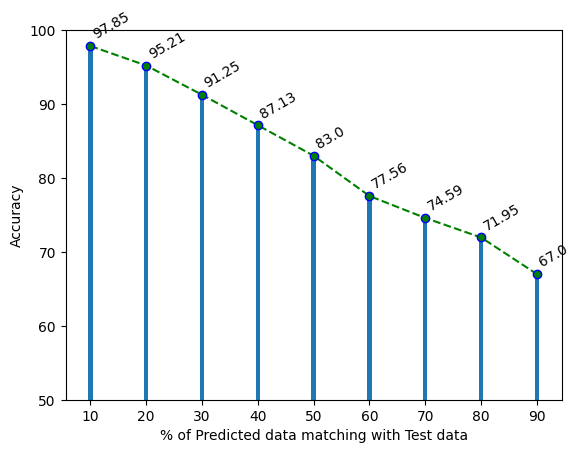

In [ ]:
nkn = np.ones((len(function_text),1))
for i in range(len(function_text)):
  ttt = " ".join(function_text[i])
  ddd = " ".join(list(data["Functions Text"][i]))
  ftn = re.split(r" ",ddd)
  c=0
  for j in range(len(ftn)):
    if(ftn[j] in ttt):
      d = ttt.find(ftn[j])
      ttt = ttt[:d] + ttt[d+len(ftn[j]):]
      c=c+1
  nkn[i] = c/len(ftn)
b = np.ones((10,2))
for i in range(1,10):
  f1 = sum(1 for nkn_item in nkn if nkn_item[0] >= i*0.1)*100
  b[i,0] = round(i*0.1,2)
  b[i,1] = round(f1/len(nkn),2)

plt.plot(b[1:,0]*100,b[1:,1],marker="o",markeredgecolor='b',linestyle="--",color='g')
plt.bar(b[1:,0]*100,b[1:,1])
for i in range(9):
  plt.text(b[i+1,0]*100,b[i+1,1]+1,b[i+1,1],rotation=30)
plt.ylim(50,100)
plt.xlabel("% of Predicted data matching with Test data")
plt.ylabel("Accuracy")
plt.show()

Background - Background: 604
Uses - Background: 492
Compare/Contrast - Background: 337
Similarities - Background: 63
Motivation - Background: 57
Differences - Background: 35
Future Work - Background: 5


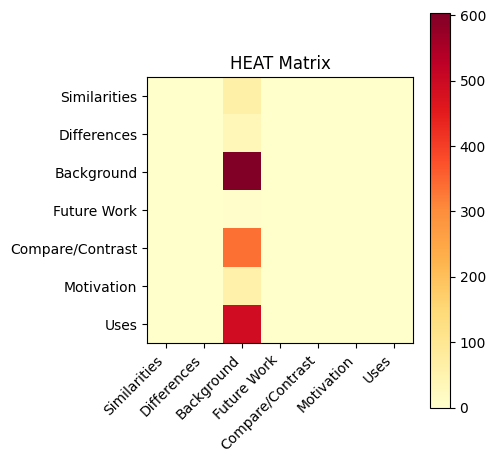

In [ ]:
import matplotlib.pyplot as plt

# Create a dictionary to store the counts for each combination of functions
hr_eat_matrix = {}
for i in range(a):
    for j in range(len(function_index[i])):
        for k in range(len(function_index[i])):
            if i != k:
                hr_func = predicted_outcome[i]
                eat_func = predicted_outcome[k]
                if (hr_func, eat_func) not in hr_eat_matrix:
                    hr_eat_matrix[(hr_func, eat_func)] = 0
                hr_eat_matrix[(hr_func, eat_func)] += 1

# Create a list of all unique function labels
unique_func_labels = list(set(predicted_outcome))

# Create a 2D array to store the counts
matrix_size = len(unique_func_labels)
count_matrix = [[0] * matrix_size for _ in range(matrix_size)]

# Fill the count_matrix with counts from the hr_eat_matrix
for i, hr_func_label in enumerate(unique_func_labels):
    for j, eat_func_label in enumerate(unique_func_labels):
        count_matrix[i][j] = hr_eat_matrix.get((hr_func_label, eat_func_label), 0)

# Create a heatmap of the counts
plt.figure(figsize=(5, 5))
plt.imshow(count_matrix, cmap='YlOrRd')
plt.colorbar()
plt.xticks(range(matrix_size), unique_func_labels, rotation=45, ha='right')
plt.yticks(range(matrix_size), unique_func_labels)
# plt.xlabel('HR Function')
# plt.ylabel('EAT Function')
plt.title('HEAT Matrix')
plt.tight_layout()

# Print the top 10 most frequent co-occurrences
top_10 = sorted(hr_eat_matrix.items(), key=lambda x: x[1], reverse=True)[:10]
for (hr_func, eat_func), count in top_10:
    print(f"{hr_func} - {eat_func}: {count}")

plt.show()

Background - Background: 604
Uses - Background: 492
Compare/Contrast - Background: 337
Similarities - Background: 63
Motivation - Background: 57
Differences - Background: 35
Future Work - Background: 5


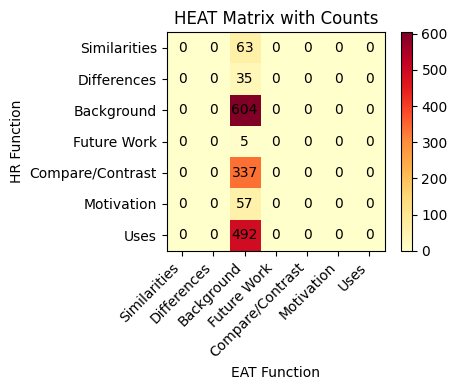

In [ ]:
import matplotlib.pyplot as plt

# Convert 'a' to an integer
a = int(a)

# Create a dictionary to store the counts for each combination of functions
hr_eat_matrix = {}
for i in range(a):
    for j in range(len(function_index[i])):
        for k in range(len(function_index[i])):
            if i != k:
                hr_func = predicted_outcome[i]
                eat_func = predicted_outcome[k]
                if (hr_func, eat_func) not in hr_eat_matrix:
                    hr_eat_matrix[(hr_func, eat_func)] = 0
                hr_eat_matrix[(hr_func, eat_func)] += 1

# Create a list of all unique function labels
unique_func_labels = list(set(predicted_outcome))

# Create a 2D array to store the counts
matrix_size = len(unique_func_labels)
count_matrix = [[0] * matrix_size for _ in range(matrix_size)]

# Fill the count_matrix with counts from the hr_eat_matrix
for i, hr_func_label in enumerate(unique_func_labels):
    for j, eat_func_label in enumerate(unique_func_labels):
        count_matrix[i][j] = hr_eat_matrix.get((hr_func_label, eat_func_label), 0)

# Create a heatmap of the counts
plt.figure(figsize=(5,4))
plt.imshow(count_matrix, cmap='YlOrRd', interpolation='nearest')

# Display counts inside the cells
for i in range(matrix_size):
    for j in range(matrix_size):
        plt.text(j, i, str(count_matrix[i][j]), ha='center', va='center', color='black')

plt.colorbar()
plt.xticks(range(matrix_size), unique_func_labels, rotation=45, ha='right')
plt.yticks(range(matrix_size), unique_func_labels)
plt.title('HEAT Matrix with Counts')
plt.xlabel('EAT Function')
plt.ylabel('HR Function')
plt.tight_layout()

# Print the top 10 most frequent co-occurrences
top_10 = sorted(hr_eat_matrix.items(), key=lambda x: x[1], reverse=True)[:10]
for (hr_func, eat_func), count in top_10:
    print(f"{hr_func} - {eat_func}: {count}")

plt.show()


In [ ]:
!pip install seqeval

In [ ]:
reference_parquet = pd.read_parquet("Validation_606.parquet")

In [ ]:
# filename = 'FOCAL-TESTING.txt'

# with open(filename, 'r') as f:
#     file_contents = f.read()

# my_variable = file_contents

# references_jsonl = sorted(my_variable, key=lambda x:x['Identifier'])

In [ ]:
# imports
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

# global param
label_list = ['Background', 'Motivation', 'Uses', 'Extends', 'Similarities', 'Differences', 'Compare/Contrast', 'Future Work', 'Unclear']

# start of function
def evaluate_FOCAL_labels(references_jsonl, predictions_jsonl, print_report=False):
    '''
    Computes precision, recall and f1-scores for the labels of citations,
    without looking at the location of these labels in the paragraph,
    between two datasets loaded from jsonl (list of dicts with same keys).
    In plain English, this checks that you correctly predicted the reason(s) a given citation was made,
    without checking if you correctly find the parts of the paragraph that explain the function of the citation.
    '''

    # sort the refs and pred by unique ID
    # references_jsonl = sorted(references_jsonl, key=lambda x:x['Identifier'])
    # predictions_jsonl = sorted(predictions_jsonl, key=lambda x:x['Identifier'])

    # assert that paragraphs match
    ref_paragraphs = list(references_jsonl["Paragraph"])
    pred_paragraphs = list(predictions_jsonl["Paragraph"])
    assert(ref_paragraphs==pred_paragraphs)


    # build y_true and y_pred
    mlb = MultiLabelBinarizer(classes=label_list)
    y_true = mlb.fit_transform(list(references_jsonl["Functions Label"]))
    y_pred = mlb.fit_transform(list(predictions_jsonl["Functions Label"]))

    # build report for printing
    report_string = classification_report(y_true=y_true,
                                          y_pred=y_pred,
                                          target_names=label_list,
                                          zero_division=0.0,
                                          output_dict=False
                                         )

    # return report as dict (can't do both at the same time? slight waste of compute)
    report_dict = classification_report(y_true=y_true,
                                        y_pred=y_pred,
                                        target_names=label_list,
                                        zero_division=0.0,
                                        output_dict=True
                                       )

    if print_report:
        print(report_string)


    return(report_dict)

d = evaluate_FOCAL_labels(reference_parquet,Final_Dataframe)
e = evaluate_FOCAL_labels(reference_parquet,Final_Dataframe)['micro avg']['f1-score']
print("\n",d)


 {'Background': {'precision': 0.6631944444444444, 'recall': 0.7100371747211895, 'f1-score': 0.6858168761220825, 'support': 269}, 'Motivation': {'precision': 0.5, 'recall': 0.2926829268292683, 'f1-score': 0.3692307692307692, 'support': 41}, 'Uses': {'precision': 0.47717842323651455, 'recall': 0.756578947368421, 'f1-score': 0.5852417302798982, 'support': 152}, 'Extends': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'Similarities': {'precision': 0.5666666666666667, 'recall': 0.40476190476190477, 'f1-score': 0.4722222222222222, 'support': 42}, 'Differences': {'precision': 0.16666666666666666, 'recall': 0.25, 'f1-score': 0.2, 'support': 16}, 'Compare/Contrast': {'precision': 0.3785310734463277, 'recall': 0.5583333333333333, 'f1-score': 0.4511784511784512, 'support': 120}, 'Future Work': {'precision': 0.5, 'recall': 0.2857142857142857, 'f1-score': 0.36363636363636365, 'support': 7}, 'Unclear': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'micro avg'

In [ ]:
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2
import numpy as np
import spacy

# preload the tokenizer
nlp = spacy.load("en_core_web_sm")
tokenizer = nlp.tokenizer

def evaluate_FOCAL_seqeval(references_jsonl, predictions_jsonl, print_reports=False):
    '''
    Computes SEQEVAL scores.
    1. convert the text into 'word' tokens using default spaCy tokenizer
    2. turn the references and the predictions into IOB2 style labels (one label per token, 'O' by default)
    3. compute f1-scores using SEQEVAL
    Returns 2 dictionaries in classification_report style, the first one with full seqeval scores,
    the second converting all the labels to a generic LABEL.
    In plain English, this 2nd one checks that you correctly found the parts of the paragraph that explain the function of the citation,
    without checking if you correctly predicted the reason(s) a given citation was made (the function labels).
    '''


    # sort the refs and pred by unique ID

  # references_jsonl = sorted(references_jsonl, key=lambda x:x['Identifier'])
    # predictions_jsonl = sorted(predictions_jsonl, key=lambda x:x['Identifier'])

    # list of columns for easier manipulation
    ref_functions_texts = list(references_jsonl["Functions Text"])
    ref_functions_labels = list(references_jsonl["Functions Label"])
    ref_functions_start_end = list(references_jsonl["Functions Start End"])
    ref_paragraphs = list(references_jsonl["Paragraph"])
    ref_indetifier = list(references_jsonl["Identifier"])

    pred_functions_texts = list(predictions_jsonl["Functions Text"])
    pred_functions_labels = list(predictions_jsonl["Functions Label"])
    pred_functions_start_end = list(predictions_jsonl["Functions Start End"])
    pred_paragraphs = list(predictions_jsonl["Paragraph"])
    pred_identifier = list(predictions_jsonl["Identifier"])

    # what will be used by classification report
    y_true_all = []
    y_pred_all = []
    y_true_generic = []
    y_pred_generic = []

    # check that ref and pred text is the same
    assert(ref_paragraphs==pred_paragraphs)

    # go through each paragraph
    for i, p in enumerate(ref_paragraphs):

        # assign to each character a ref_label and pred_label
        ref_labels_char = ['O' for _ in p]
        pred_labels_char = ['O' for _ in p]

        # go through each ref function to verify the data
        for j,(start,end) in enumerate(ref_functions_start_end[i]):
            # check that the text of the ref function matches the paragraph [start:end] section defined by the ref's start:end
            assert_err_string = 'ref function text doesnt match paragraph[start:end]:\nID:{} {}\nfunction text: {}\nparagraph[start:end]:{}'.format(i, ref_indetifier[i], ref_functions_texts[i][j], p[start:end])
            assert p[start:end]==ref_functions_texts[i][j], assert_err_string

            # fill in the char level labels
            ref_labels_char[start] = 'B-'+ ref_functions_labels[i][j]
            for position in range(start+1, end):
                ref_labels_char[position] = 'I-'+ ref_functions_labels[i][j]


        # do the same for the pred functions
        for j,(start,end) in enumerate(pred_functions_start_end[i]):
            # # check that the text of the pred function matches the paragraph [start:end] section defined by the pred's start:end
            # assert_err_string = 'pred function text doesnt match paragraph[start:end]:\nID:{} {}\nfunction text: {}\nparagraph[start:end]:{}'.format(i, pred_identifier[i], pred_functions_texts[i][j], p[start:end])
            # assert p[start:end]==pred_functions_texts[i][j], assert_err_string

            # fill in the char level labels
            pred_labels_char[start] = 'B-'+ pred_functions_labels[i][j]
            for position in range(start+1, end):
                pred_labels_char[position] = 'I-'+ pred_functions_labels[i][j]

        # tokenize the text
        tokens = tokenizer(p)


        # assign to each token a ref_label and a pred_label
        ref_labels_tokens = ['O' for _ in tokens]
        pred_labels_tokens = ['O' for _ in tokens]
        # same but with making all labels the same generic label
        ref_labels_tokens_generic= ['O' for _ in tokens]
        pred_labels_tokens_generic = ['O' for _ in tokens]

        for token_idx, token in enumerate(tokens):
            # note that token_idx is the position in tokens
            # and token.idx the position in characters

            # heuristics to assign label
            # assign the first non-'O' label we find

            # for refs
            label = next((x for x in ref_labels_char[token.idx: token.idx+len(token)] if x!='O'), 'O')
            if label!='O':
                # if the label starts on a white space, we might miss the B- since the tokenizer often skips whitespaces
                # check if we need to change an I- into a B-
                if label[:2]=='I-':
                    if token_idx==0 or (ref_labels_tokens!=ref_labels_tokens[token_idx-1]):
                        label='B-'+label[2:]
                ref_labels_tokens[token_idx] = label
                # use the B- or I- portion of the label for the generic label
                ref_labels_tokens_generic[token_idx] = label[:2] + 'LABEL'

            # based on construction, we should never have an I- label without either an I- or B- label before
            if token_idx==0:
                assert(label=='O' or label.startswith('B-'))
            else:
                if label.startswith('I-'):
                    # check prev label is same
                    assert(label[2:]==ref_labels_tokens[token_idx-1][2:] )

            # for preds
            label = next((x for x in pred_labels_char[token.idx: token.idx+len(token)] if x!='O'), 'O')

            if label!='O':
                if label[:2]=='I-':
                    if token_idx==0 or (pred_labels_tokens!=pred_labels_tokens[token_idx-1]):
                        label='B-'+label[2:]
                pred_labels_tokens[token_idx] = label
                # use the B- or I- portion of the label for the generic label
                pred_labels_tokens_generic[token_idx] = label[:2] + 'LABEL'

            # based on construction, we should never have an I- label without either an I- or B- label before
            if token_idx==0:
                assert(label=='O' or label.startswith('B-'))
            else:
                if label.startswith('I-'):
                    # check prev label is same
                    assert(label[2:]==pred_labels_tokens[token_idx-1][2:] )

        y_true_all.append(ref_labels_tokens)
        y_pred_all.append(pred_labels_tokens)

        y_true_generic.append(ref_labels_tokens_generic)
        y_pred_generic.append(pred_labels_tokens_generic)



    # now we can evaluate using seqeval
    # build report for printing
    report_string_all = classification_report(y_true=y_true_all,
                                              y_pred=y_pred_all,
                                              scheme=IOB2,
                                              zero_division=0.0,
                                              output_dict=False
                                              )

    # return report as dict (can't do both at the same time? slight waste of compute)
    report_dict_all = classification_report(y_true=y_true_all,
                                            y_pred=y_pred_all,
                                            scheme=IOB2,
                                            zero_division=0.0,
                                            output_dict=True
                                           )
    if print_reports:
        print(report_string_all)

    report_string_generic = classification_report(y_true=y_true_generic,
                                              y_pred=y_pred_generic,
                                              scheme=IOB2,
                                              zero_division=0.0,
                                              output_dict=False
                                              )

    # return report as dict (can't do both at the same time? slight waste of compute)
    report_dict_generic = classification_report(y_true=y_true_generic,
                                            y_pred=y_pred_generic,
                                            scheme=IOB2,
                                            zero_division=0.0,
                                            output_dict=True
                                           )
    if print_reports:
        print(report_string_generic)

    return(report_dict_all, report_dict_generic)

c = evaluate_FOCAL_seqeval(reference_parquet, Final_Dataframe)
a = evaluate_FOCAL_seqeval(reference_parquet, Final_Dataframe)[0]['micro avg']['f1-score']
b = evaluate_FOCAL_seqeval(reference_parquet, Final_Dataframe)[1]['micro avg']['f1-score']
print(c)

({'Background': {'precision': 0.44116834055099974, 'recall': 0.5470124528733006, 'f1-score': 0.48842191165969606, 'support': 8753}, 'Compare/Contrast': {'precision': 0.29466479466479467, 'recall': 0.3193229364777482, 'f1-score': 0.30649872216137275, 'support': 5258}, 'Differences': {'precision': 0.13524590163934427, 'recall': 0.13807531380753138, 'f1-score': 0.13664596273291926, 'support': 478}, 'Extends': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 188}, 'Future Work': {'precision': 0.3413173652694611, 'recall': 0.22983870967741934, 'f1-score': 0.2746987951807229, 'support': 248}, 'Motivation': {'precision': 0.34915924826904055, 'recall': 0.21803582458307597, 'f1-score': 0.26844106463878326, 'support': 1619}, 'Similarities': {'precision': 0.49164926931106473, 'recall': 0.33570919458303633, 'f1-score': 0.39898348157560354, 'support': 1403}, 'Uses': {'precision': 0.34360672440142637, 'recall': 0.5201465201465202, 'f1-score': 0.41383541682644376, 'support': 5187}, 'micr

In [ ]:
print("\n",a,"\n",b,"\n",e)


 0.40318175474970597 
 0.6877055880066186 
 0.5678496868475992
